In [1]:
#imports
from scripts import bookdatafunctions as bdf
from scripts import corpusMLfunctions as cmf
import pandas as pd
import numpy as np
import os
from pprint import pprint
import json

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#constants
#Imports
from scripts import bookdatafunctions as bdf
from scripts import corpusMLfunctions as cmf
import pandas as pd
import numpy as np
from datasets import Dataset, disable_progress_bars
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import f1_score
import optuna
import json
import multiprocessing as mp
import shutil
import warnings
from tqdm import tqdm

#Constants
AGES = ['5','6','7','8','9','10','11','12','13','14','15']
KEYLISTS = "Keylists.jsonl"
keylists = []
with open(KEYLISTS, 'r') as f:
    for line in f:
        keylists.append(json.loads(line))

#Dataset name
DATASET = "TCBC_datasets/sniplen50_hpfv"

#Helper functions
def do_nothing(ex):
    return ex.lower()

def conllu_tokenizer(ex):
    return ex.replace("\n", "\t").replace("|", "\t").split("\t")

def whitespace_tokenizer(ex):
    return ex.split(" ")

In [3]:
train_keys = keylists[69]['train_keys']
eval_keys = keylists[69]['eval_keys']
test_keys = keylists[69]['test_keys']

In [4]:
def assignLabel(ex):
    age = int(bdf.findAgeFromID(ex))
    if age < 9:
        return '7-8'
    elif age < 13:
        return '9-12'
    else:
        return '13+'

def conllu2RawLemmas(conllu_text):
    conllu_lines = conllu_text.split("\n")
    return " ".join([x.split('\t')[2] for x in conllu_lines if len(x) > 0])


def mapLabels(ex):
    return {'label':[assignLabel(x) for x in ex['book_id']]}

def mapConlluData2RawLemmas(ex):
    return {'data':[conllu2RawLemmas(x) for x in ex['data']]}


In [5]:
ds = Dataset.load_from_disk(DATASET)
#Training dataset
train_ds = ds.filter(lambda x: x['book_id'] in train_keys).shuffle()
train_ds = train_ds.map(mapLabels, batched=True, batch_size=32, load_from_cache_file=False)
#train_ds = train_ds.map(mapConlluData2RawLemmas, batched=True, batch_size=16, load_from_cache_file=False)

Map: 100%|██████████| 17534/17534 [00:00<00:00, 44167.19 examples/s]


In [6]:
#Evaluation dataset
eval_ds = ds.filter(lambda x: x['book_id'] in eval_keys).shuffle()
eval_ds = eval_ds.map(mapLabels, batched=True, batch_size=32, load_from_cache_file=False)
#eval_ds = eval_ds.map(mapConlluData2RawLemmas, batched=True, batch_size=16, load_from_cache_file=False)

Map: 100%|██████████| 3153/3153 [00:00<00:00, 44066.86 examples/s]


In [7]:
#Test dataset
test_ds = ds.filter(lambda x: x['book_id'] in test_keys).shuffle()
test_ds = test_ds.map(mapLabels, batched=True, batch_size=32, load_from_cache_file=False)
#test_ds = test_ds.map(mapConlluData2RawLemmas, batched=True, batch_size=16, load_from_cache_file=False)

Map: 100%|██████████| 2650/2650 [00:00<00:00, 26242.75 examples/s]


In [8]:
#Initialize and fir our vectorizer
#vectorizer = TfidfVectorizer(norm='l2', tokenizer=whitespace_tokenizer, preprocessor=do_nothing, max_features=2000).fit([x['data'] for x in train_ds])
#Vectorize datasets
#vectorized_train = vectorizer.transform([x['data'] for x in train_ds])
#vectorized_eval = vectorizer.transform([x['data'] for x in eval_ds])
#vectorized_test = vectorizer.transform([x['data'] for x in test_ds])

In [9]:
#For testing purposes
expected_good = [17, 80, 88, 108, 118, 133, 134, 149, 165, 170, 174, 181, 198, 222, 246, 261, 303, 323, 335, 336]

In [10]:
#vectorized_train = np.array(train_ds['data'])[:,expected_good]
#vectorized_eval = np.array(eval_ds['data'])[:,expected_good]
#vectorized_test = np.array(test_ds['data'])[:,expected_good]
vectorized_train = np.array(train_ds['data'])
vectorized_eval = np.array(eval_ds['data'])
vectorized_test = np.array(test_ds['data'])

In [18]:
returnable = {}
c_eval_pairs= []
from sklearn.multiclass import OneVsOneClassifier

#Very quick hyperparam optimization as we have computational resources
def objective(trial):
    #Defining hyperparameters to tune
    c = trial.suggest_float('c', 1e-10, 1e+0, log=True)
    pen = trial.suggest_categorical('pen', ['l2'])
    tol = trial.suggest_float('tol', 1e-10, 1e-3, log=True)
    clf = OneVsOneClassifier(LinearSVC(
        random_state=42,
        C=c,
        tol=tol,
        penalty=pen
    ))
    clf.fit(vectorized_train,train_ds['label'])
    predicted = clf.predict(vectorized_eval)
    f1 = f1_score(eval_ds['label'], predicted, average="macro")
    c_eval_pairs.append([c, f1])
    return f1

# Your code for hyperparameter optimization here
study = optuna.create_study(direction='maximize')
optuna.logging.disable_default_handler()
study.optimize(objective, n_trials=25)

#Run with best params
clf = OneVsOneClassifier(LinearSVC(
    penalty=study.best_trial.params['pen'],
    random_state=42,
    C=study.best_trial.params['c'],
    tol=study.best_trial.params['tol'],
))
clf.fit(vectorized_train, train_ds['label'])
test_predict = clf.predict(vectorized_test)

#Assign returnble values
returnable['f1'] = f1_score(test_ds['label'], test_predict, average="macro")
returnable['labels'] = clf.classes_.tolist()
returnable['conf_matrix'] = metrics.confusion_matrix(test_ds['label'], test_predict).tolist()
returnable['c'] = study.best_trial.params['c']
returnable['tol'] = study.best_trial.params['tol']
returnable['penalty'] = study.best_trial.params['pen']
returnable['c_eval_scores'] = c_eval_pairs

In [19]:
pprint(returnable)

{'c': 0.35544041183276004,
 'c_eval_scores': [[8.756943690747651e-07, 0.3492836397012598],
                   [0.0001982006522149772, 0.39768164387651],
                   [2.6002388937832857e-05, 0.381475482115934],
                   [2.996824020871458e-08, 0.21905884121584782],
                   [2.7215957532674433e-09, 0.2157872157872158],
                   [0.005421978528632021, 0.42891602694357767],
                   [2.3990137197240475e-10, 0.2157872157872158],
                   [0.08050737418905411, 0.4448447543197809],
                   [0.024594836061400394, 0.4395993809271772],
                   [0.9202172894016388, 0.4446271271479969],
                   [0.7796061260620512, 0.44352385708791564],
                   [0.35544041183276004, 0.44522520143742444],
                   [0.0054040631085704996, 0.42891602694357767],
                   [0.04042516031982929, 0.44170424329414276],
                   [0.00032270172186503297, 0.40201190610031495],
                   

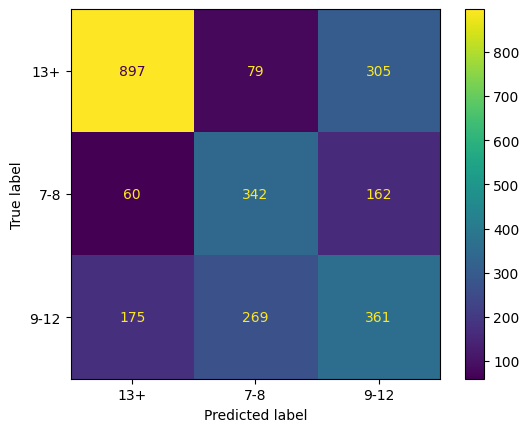

In [20]:
p = metrics.ConfusionMatrixDisplay(confusion_matrix=np.array(returnable['conf_matrix']), display_labels=returnable['labels'])
p.plot()

In [21]:
high_prio = {}
# make a list of (weight, index), sort it
for j in clf.classes_:
    lst=[]
    for idx,weight in enumerate(clf.coef_[list(clf.classes_).index(j)]):
        lst.append((weight,idx))
    lst.sort() #sort
    highest_prio = []
    for weight,idx in lst[-100:][::-1]:
        highest_prio.append(idx)
    high_prio[j] = highest_prio
for h in high_prio:
    returnable['important_features_for_'+h] = high_prio[h]

AttributeError: 'OneVsOneClassifier' object has no attribute 'coef_'

In [ ]:
test_conllu_line = "1\tAikojen\taika\tNOUN\tN\tCase=Gen|Number=Plur\t2\tnsubj\t_\t_\n2\tkuluessa\tkulua\tVERB\tV\tCase=Ine|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t7\tadvcl\t_\t_\n3\tmuinaisina\tmuinainen\tADJ\tA\tCase=Ess|Degree=Pos|Derivation=Inen|Number=Plur\t4\tamod\t_\t_\n4\taikoina\taika\tNOUN\tN\tCase=Ess|Number=Plur\t5\tobl\t_\t_\n5\tsyntynyt\tsynty\u00e4\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t6\tacl\t_\t_\n6\tpahuus\tpahuus\tNOUN\tN\tCase=Nom|Derivation=Vs|Number=Sing\t7\tnsubj\t_\t_\n7\tkasvaa\tkasvaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n8\t,\t,\tPUNCT\tPunct\t_\t12\tpunct\t_\t_\n9\ti\u00e4inen\ti\u00e4inen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Inen|Number=Sing\t10\tamod\t_\t_\n10\tpimeys\tpimeys\tNOUN\tN\tCase=Nom|Derivation=Vs|Number=Sing\t12\tnsubj:cop\t_\t_\n11\ton\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t12\tcop\t_\t_\n12\tvalloillaan\tvalloillaan\tADV\tAdv\t_\t7\tconj\t_\t_\n13\tja\tja\tCCONJ\tC\t_\t14\tcc\t_\t_\n14\tyritt\u00e4\u00e4\tyritt\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t7\tconj\t_\t_\n15\tsy\u00f6st\u00e4\tsy\u00f6st\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t14\txcomp\t_\t_\n16\tkoko\tkoko\tADJ\tA\t_\t17\tamod\t_\t_\n17\tmaan\tmaa\tNOUN\tN\tCase=Gen|Number=Sing\t15\tobj\t_\t_\n18\tp\u00e4\u00e4ttym\u00e4tt\u00f6m\u00e4\u00e4n\tp\u00e4\u00e4ttym\u00e4t\u00f6n\tADJ\tA\tCase=Ill|Degree=Pos|Derivation=Ton|Number=Sing\t19\tamod\t_\t_\n19\ty\u00f6h\u00f6n\ty\u00f6\tNOUN\tN\tCase=Ill|Number=Sing\t15\tobl\t_\t_\n20\t.\t.\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n1\tT\u00e4t\u00e4\tt\u00e4m\u00e4\tPRON\tPron\tCase=Par|Number=Sing|PronType=Dem\t2\tdet\t_\t_\n2\tpahuutta\tpahuutta\tNOUN\tN\tCase=Par|Derivation=Vs|Number=Sing\t5\tobj\t_\t_\n3\tei\tei\tAUX\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t5\taux\t_\t_\n4\tvoi\tvoida\tAUX\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t5\taux\t_\t_\n5\tly\u00f6d\u00e4\tly\u00f6d\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t0\troot\t_\t_\n6\tkukaan\tkukaan\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t5\tnsubj\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t18\tpunct\t_\t_\n8\tpaitsi\tpaitsi\tADP\tAdp\t_\t18\tcase\t_\t_\n9\tyksi\tyksi\tNUM\tNum\tCase=Nom|Number=Sing|NumType=Card\t18\tnummod\t_\t_\n10\tja\tja\tCCONJ\tC\t_\t11\tcc\t_\t_\n11\tainoa\tainoa\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t9\tconj\t_\t_\n12\tValveuden\tvalveus\tNOUN\tN\tCase=Gen|Derivation=Vs|Number=Sing\t13\tnsubj\t_\t_\n13\tvalitsema\tvalita\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Agt|VerbForm=Part|Voice=Act\t18\tacl\t_\t_\n14\t,\t,\tPUNCT\tPunct\t_\t18\tpunct\t_\t_\n15\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t17\tnsubj\t_\t_\n16\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t15\tflat:name\t_\t_\n17\ttuleva\ttulla\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t18\tacl\t_\t_\n18\tsankari\tsankari\tNOUN\tN\tCase=Nom|Number=Sing\t6\tappos\t_\t_\n19\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\tVirheet\u00f6n\tvirheet\u00f6n\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Ton|Number=Sing\t2\tamod\t_\t_\n2\tmies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n4\tjoka\tjoka\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Rel\t5\tnsubj\t_\t_\n5\tkantaa\tkantaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t2\tacl:relcl\t_\t_\n6\tvalon\tvalo\tNOUN\tN\tCase=Gen|Number=Sing\t7\tnmod:poss\t_\t_\n7\tamulettia\tamuletti\tNOUN\tN\tCase=Par|Number=Sing\t5\tobj\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t10\tcc\t_\t_\n9\tt\u00e4ydellisesti\tt\u00e4ydellisesti\tADV\tAdv\tDerivation=Sti\t10\tadvmod\t_\t_\n10\tt\u00e4ytt\u00e4\u00e4\tt\u00e4ytt\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t5\tconj\t_\t_\n11\tValveuden\tvalveus\tNOUN\tN\tCase=Gen|Derivation=Vs|Number=Sing\t12\tnmod:poss\t_\t_\n12\ttahdon\ttahto\tNOUN\tN\tCase=Gen|Number=Sing\t10\tobj\t_\t_\n13\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tKun\tkun\tSCONJ\tC\t_\t4\tmark\t_\t_\n2\taika\taika\tNOUN\tN\tCase=Nom|Number=Sing\t4\tnsubj:cop\t_\t_\n3\ton\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tcop\t_\t_\n4\tt\u00e4ysi\tt\u00e4ysi\tADJ\tA\tCase=Nom|Degree=Pos|Number=Sing\t7\tadvcl\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n6\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t7\tnsubj\t_\t_\n7\tuhraa\tuhrata\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n8\titsens\u00e4\titse\tPRON\tPron\tCase=Gen|Number=Sing|Person[psor]=3|Reflex=Yes\t7\tobj\t_\t_\n9\tkaikkien\tkaikki\tPRON\tPron\tCase=Gen|Number=Plur|PronType=Ind\t7\tobl\t_\t_\n10\tpuolesta\tpuolesta\tADP\tAdp\tAdpType=Post\t9\tcase\t_\t_\n11\ttaistelussa\ttaistelu\tNOUN\tN\tCase=Ine|Derivation=U|Number=Sing\t7\tobl\t_\t_\n12\tpimeytt\u00e4\tpimeys\tNOUN\tN\tCase=Par|Derivation=Vs|Number=Sing\t11\tnmod\t_\t_\n13\tvastaan\tvastaan\tADP\tAdp\tAdpType=Post\t12\tcase\t_\t_\n14\t,\t,\tPUNCT\tPunct\t_\t18\tpunct\t_\t_\n15\tmutta\tmutta\tCCONJ\tC\t_\t18\tcc\t_\t_\n16\tkuolemakaan\tkuolema\tNOUN\tN\tCase=Nom|Clitic=Kaan|Number=Sing\t18\tnsubj\t_\t_\n17\tei\tei\tAUX\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t18\taux\t_\t_\n18\tsaa\tsaada\tVERB\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t7\tconj\t_\t_\n19\th\u00e4nest\u00e4\th\u00e4n\tPRON\tPron\tCase=Ela|Number=Sing|Person=3|PronType=Prs\t18\tobl\t_\t_\n20\tvoittoa\tvoitto\tNOUN\tN\tCase=Par|Number=Sing\t18\tobj\t_\t_\n21\t.\t.\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n1\tValittu\tvalita\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Pass\t2\tnsubj\t_\t_\n2\tvoittaa\tvoittaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tlopullisesti\tlopullisesti\tADV\tAdv\tDerivation=Sti\t2\tadvmod\t_\t_\n4\t\t\tPROPN\tN\tCase=Gen|Number=Sing\t2\tobj\t_\t_\n5\tjoukkoineen\tjoukko\tNOUN\tN\tCase=Com|Person[psor]=3\t4\tnmod\t_\t_\n6\t,\t,\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n7\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n8\tmaailmaan\tmaailma\tNOUN\tN\tCase=Ill|Number=Sing\t9\tobl\t_\t_\n9\tpalaa\tpalata\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n10\thyvyys\thyvyys\tNOUN\tN\tCase=Nom|Number=Sing\t9\tnsubj\t_\t_\n11\tja\tja\tCCONJ\tC\t_\t12\tcc\t_\t_\n12\trauha\trauha\tNOUN\tN\tCase=Nom|Number=Sing\t10\tconj\t_\t_\n13\tkuin\tkuin\tSCONJ\tC\t_\t15\tmark\t_\t_\n14\tentisin\u00e4\tentinen\tADJ\tA\tCase=Ess|Degree=Pos|Derivation=Inen|Number=Plur\t15\tamod\t_\t_\n15\taikoina\taika\tNOUN\tN\tCase=Ess|Number=Plur\t9\tadvcl\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tJa\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n2\tkaikki\tkaikki\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t9\tnsubj\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n4\tjotka\tjoka\tPRON\tPron\tCase=Nom|Number=Plur|PronType=Rel\t7\tnsubj\t_\t_\n5\tovat\tolla\tAUX\tV\tMood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t7\taux\t_\t_\n6\tvalittua\tvalittu\tNOUN\tN\tCase=Par|Number=Sing\t7\tobj\t_\t_\n7\tseuranneet\tseurata\tVERB\tV\tCase=Nom|Degree=Pos|Number=Plur|PartForm=Past|VerbForm=Part|Voice=Act\t2\tacl:relcl\t_\t_\n8\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n9\tp\u00e4\u00e4sev\u00e4t\tp\u00e4\u00e4st\u00e4\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n10\th\u00e4nen\th\u00e4n\tPRON\tPron\tCase=Gen|Number=Sing|Person=3|PronType=Prs\t9\tobl\t_\t_\n11\tkanssaan\tkanssa\tADP\tAdp\tAdpType=Post|Person[psor]=3\t10\tcase\t_\t_\n12\tValveuden\tvalveus\tNOUN\tN\tCase=Gen|Derivation=Vs|Number=Sing\t9\tobl\t_\t_\n13\tluo\tluo\tADP\tAdp\tAdpType=Post\t12\tcase\t_\t_\n14\tikuiseen\tikuinen\tADJ\tA\tCase=Ill|Degree=Pos|Derivation=Inen|Number=Sing\t15\tamod\t_\t_\n15\tiloon\tilo\tNOUN\tN\tCase=Ill|Number=Sing\t9\tobl\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tJoten\tjoten\tADV\tAdv\t_\t3\tadvmod\t_\t_\n3\tryhdy\tryhty\u00e4\tVERB\tV\tMood=Imp|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\tsin\u00e4kin\tsin\u00e4\tPRON\tPron\tCase=Nom|Clitic=Kin|Number=Sing|Person=2|PronType=Prs\t3\tnsubj\t_\t_\n5\tvalittu-ehdokkaaksi\tvalittu#ehdokas\tNOUN\tN\tCase=Tra|Number=Sing\t3\txcomp:ds\t_\t_\n6\t!\t!\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tJos\tjos\tSCONJ\tC\t_\t3\tmark\t_\t_\n2\tet\tei\tAUX\tV\tNumber=Sing|Person=2|Polarity=Neg|VerbForm=Fin|Voice=Act\t3\taux\t_\t_\n3\tkuole\tkuolla\tVERB\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t9\tadvcl\t_\t_\n4\theti\theti\tADV\tAdv\t_\t6\tadvmod\t_\t_\n5\tensimm\u00e4isess\u00e4\tensimm\u00e4inen\tADJ\tNum\tCase=Ine|Derivation=Inen|Number=Sing|NumType=Ord\t6\tamod\t_\t_\n6\ttaistelussa\ttaistelu\tNOUN\tN\tCase=Ine|Derivation=U|Number=Sing\t3\tobl\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n8\tsaatat\tsaattaa\tAUX\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t9\taux\t_\t_\n9\tvoittaa\tvoittaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t0\troot\t_\t_\n10\tikuisen\tikuinen\tADJ\tA\tCase=Gen|Degree=Pos|Derivation=Inen|Number=Sing\t11\tamod\t_\t_\n11\tel\u00e4m\u00e4n\tel\u00e4m\u00e4\tNOUN\tN\tCase=Gen|Number=Sing\t9\tobj\t_\t_\n12\t!\t!\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n13\t\"\t\"\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n2\tEnt\u00e4\tent\u00e4\tADV\tAdv\t_\t5\tadvmod\t_\t_\n3\tjos\tjos\tSCONJ\tC\t_\t5\tmark\t_\t_\n4\ten\tei\tAUX\tV\tNumber=Sing|Person=1|Polarity=Neg|VerbForm=Fin|Voice=Act\t5\taux\t_\t_\n5\thalua\thaluta\tVERB\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t0\troot\t_\t_\n6\t?\t?\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n7\t\"\t\"\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n8\tmin\u00e4\tmin\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|Person=1|PronType=Prs\t9\tnsubj\t_\t_\n9\tkysyin\tkysy\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=1|Tense=Past|VerbForm=Fin|Voice=Act\t5\tparataxis\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n2\t\u00c4l\u00e4\tei\tAUX\tV\tMood=Imp|Number=Sing|Person=2|Polarity=Neg|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n3\tole\tolla\tAUX\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t4\tcop\t_\t_\n4\tpelkuri\tpelkuri\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n5\t!\t!\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n6\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n7\tjyr\u00e4htiv\u00e4t\tjyr\u00e4ht\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t4\tparataxis\t_\t_\n8\thyvikset\thyvi\tADJ\tA\tCase=Nom|Number=Plur\t7\tnsubj\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n2\tOnko\tolla\tAUX\tV\tClitic=Ko|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tcop\t_\t_\n3\tmeiss\u00e4\tmin\u00e4\tPRON\tPron\tCase=Ine|Number=Plur|PronType=Dem\t4\tobl\t_\t_\n4\tkeness\u00e4k\u00e4\u00e4n\tkukaan\tPRON\tPron\tCase=Ine|Number=Sing|PronType=Ind\t0\troot\t_\t_\n5\tmit\u00e4\u00e4n\tmik\u00e4\u00e4n\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t4\tnsubj:cop\t_\t_\n6\tpelastamisen\tpelastaminen\tNOUN\tN\tCase=Gen|Derivation=Minen|Number=Sing\t7\tnmod:poss\t_\t_\n7\tarvoista\tarvoinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Inen|Number=Sing\t5\tnmod\t_\t_\n8\t?\t?\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tSiet\u00e4isimme\tsiet\u00e4\u00e4\tVERB\tV\tMood=Cnd|Number=Plur|Person=1|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n2\tkaikki\tkaikki\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t1\tobj\t_\t_\n3\tkuolla\tkuolla\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t1\txcomp\t_\t_\n4\t\"\t\"\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\tmutisi\tmutista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t1\tparataxis\t_\t_\n7\tViikatemies\tviikate#mies\tNOUN\tN\tCase=Nom|Number=Sing\t6\tnsubj\t_\t_\n8\t.\t.\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tParas\thyv\u00e4\tADJ\tA\tCase=Nom|Degree=Sup|Number=Sing\t0\troot\t_\t_\n3\titse\titse\tADV\tAdv\t_\t5\tadvmod\t_\t_\n4\titsens\u00e4\titse\tPRON\tPron\tCase=Gen|Number=Sing|Person[psor]=3|Reflex=Yes\t5\tobj\t_\t_\n5\tpelastaa\tpelastaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t2\txcomp:ds\t_\t_\n6\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n8\ttokaisi\ttokaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n9\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t8\tnsubj\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tTe\tsin\u00e4\tPRON\tPron\tCase=Nom|Number=Plur|Person=2|PronType=Prs\t3\tnsubj:cop\t_\t_\n3\tharhaoppiset\tharhaoppinen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Inen|Number=Plur\t0\troot\t_\t_\n4\t!\t!\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tHirteen\thirre\tNOUN\tN\tCase=Ill|Number=Sing\t2\tobl\t_\t_\n2\tjoudatte\tjoudattaa\tVERB\tV\tMood=Ind|Number=Plur|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\t!\t!\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n5\tpauhasivat\tpauhata\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n6\thyvikset\thyvi\tADJ\tA\tCase=Nom|Number=Plur\t5\tnsubj\t_\t_\n7\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMin\u00e4\tmin\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|Person=1|PronType=Prs\t3\tnsubj\t_\t_\n2\ten\tei\tAUX\tV\tNumber=Sing|Person=1|Polarity=Neg|VerbForm=Fin|Voice=Act\t3\taux\t_\t_\n3\tuskaltanut\tuskaltaa\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t0\troot\t_\t_\n4\tmainitakaan\tmainita\tVERB\tV\tClitic=Kaan|InfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t3\txcomp\t_\t_\n5\tmuista\tmuu\tPRON\tPron\tCase=Ela|Number=Plur|PronType=Ind\t6\tdet\t_\t_\n6\tmahdollisuuksista\tmahdollisuus\tNOUN\tN\tCase=Ela|Derivation=Llinen,Vs|Number=Plur\t4\tobl\t_\t_\n7\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n8\tniin\tniin\tADV\tAdv\t_\t9\tadvmod\t_\t_\n9\tlopetin\tlopettaa\tVERB\tV\tMood=Ind|Number=Sing|Person=1|Tense=Past|VerbForm=Fin|Voice=Act\t3\tconj\t_\t_\n10\tt\u00e4m\u00e4n\tt\u00e4m\u00e4\tPRON\tPron\tCase=Gen|Number=Sing|PronType=Dem\t11\tdet\t_\t_\n11\tpaperin\tpaperi\tNOUN\tN\tCase=Gen|Number=Sing\t12\tnmod:gobj\t_\t_\n12\ttuhlaamisen\ttuhlaaminen\tNOUN\tN\tCase=Gen|Derivation=Minen|Number=Sing\t9\tobj\t_\t_\n13\t,\t,\tPUNCT\tPunct\t_\t16\tpunct\t_\t_\n14\tkoska\tkoska\tSCONJ\tC\t_\t16\tmark\t_\t_\n15\ttila\ttila\tNOUN\tN\tCase=Nom|Number=Sing\t16\tnsubj\t_\t_\n16\tloppuu\tloppua\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t9\tadvcl\t_\t_\n17\tja\tja\tCCONJ\tC\t_\t21\tcc\t_\t_\n18\tminun\tmin\u00e4\tPRON\tPron\tCase=Gen|Number=Sing|Person=1|PronType=Prs\t21\tnsubj\t_\t_\n19\tpit\u00e4isi\tpit\u00e4\u00e4\tAUX\tV\tMood=Cnd|Number=Sing|Person=3|VerbForm=Fin|Voice=Act\t21\taux\t_\t_\n20\tolla\tolla\tAUX\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t21\taux\t_\t_\n21\ttekem\u00e4ss\u00e4\ttehd\u00e4\tVERB\tV\tCase=Ine|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t16\tconj\t_\t_\n22\tjotain\tjokin\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t24\tdet\t_\t_\n23\toikeasti\toikeasti\tADV\tAdv\tDerivation=Sti\t24\tadvmod\t_\t_\n24\thy\u00f6dyllist\u00e4\thy\u00f6dyllinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Llinen|Number=Sing\t21\tobj\t_\t_\n25\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\thuokaisi\thuokaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tsyv\u00e4\u00e4n\tsyv\u00e4\u00e4n\tADV\tAdv\t_\t2\tadvmod\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n5\tlaski\tlaskea\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\tkyn\u00e4n\tkyn\u00e4\tNOUN\tN\tCase=Gen|Number=Sing\t5\tobj\t_\t_\n7\tmustepulloon\tmuste#pullo\tNOUN\tN\tCase=Ill|Number=Sing\t5\tobl\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n9\tj\u00e4i\tj\u00e4\u00e4d\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n10\tkatsomaan\tkatsoa\tVERB\tV\tCase=Ill|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t9\txcomp\t_\t_\n11\thorisonttiin\thorisontti\tNOUN\tN\tCase=Ill|Number=Sing\t10\tobl\t_\t_\n12\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tPahuksen\tpahus\tNOUN\tN\tCase=Gen|Number=Sing\t3\tnmod:poss\t_\t_\n3\tprofetia\tprofetia\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n4\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n5\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tLinnan\tlinna\tNOUN\tN\tCase=Gen|Number=Sing\t2\tnmod:poss\t_\t_\n2\tkorkeimmasta\tkorkea\tADJ\tA\tCase=Ela|Degree=Sup|Number=Sing\t3\tamod\t_\t_\n3\ttornista\ttorni\tNOUN\tN\tCase=Ela|Number=Sing\t4\tobl\t_\t_\n4\tn\u00e4ki\tn\u00e4hd\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=0|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n5\tymp\u00e4r\u00f6iv\u00e4n\tymp\u00e4r\u00f6id\u00e4\tVERB\tV\tCase=Gen|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t6\tacl\t_\t_\n6\tkaupungin\tkaupunki\tNOUN\tN\tCase=Gen|Number=Sing\t11\tnmod\t_\t_\n7\tja\tja\tCCONJ\tC\t_\t8\tcc\t_\t_\n8\tpeltomaiden\tpelto#maa\tNOUN\tN\tCase=Gen|Number=Plur\t6\tconj\t_\t_\n9\tyli\tyli\tADP\tAdp\tAdpType=Post\t6\tcase\t_\t_\n10\tautioon\tautio\tADJ\tA\tCase=Ill|Degree=Pos|Number=Sing\t11\tamod\t_\t_\n11\treunaseutuun\treuna#seutu\tNOUN\tN\tCase=Ill|Number=Sing\t4\tobl\t_\t_\n12\t,\t,\tPUNCT\tPunct\t_\t15\tpunct\t_\t_\n13\tjoka\tjoka\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Rel\t15\tnsubj\t_\t_\n14\tv\u00e4hitellen\tv\u00e4hitellen\tADV\tAdv\t_\t15\tadvmod\t_\t_\n15\tnousi\tnousta\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t11\tacl:relcl\t_\t_\n16\tsynkkyytt\u00e4\tsynkkyys\tNOUN\tN\tCase=Par|Number=Sing\t17\tobj\t_\t_\n17\thuokuvaksi\thuokua\tVERB\tV\tCase=Tra|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t18\tacl\t_\t_\n18\tvuoristoksi\tvuoristo\tNOUN\tN\tCase=Tra|Number=Sing\t15\txcomp\t_\t_\n19\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tsiirtyi\tsiirty\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tvieress\u00e4\u00e4n\tvieress\u00e4\tADV\tAdv\tPerson[psor]=3\t4\tadvmod\t_\t_\n4\tolevan\tolla\tVERB\tV\tCase=Gen|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t6\tacl\t_\t_\n5\tjyhke\u00e4n\tjyhke\u00e4\tADJ\tA\tCase=Gen|Degree=Pos|Number=Sing\t6\tamod\t_\t_\n6\tkaukoputken\tkauko#putki\tNOUN\tN\tCase=Gen|Number=Sing\t2\tobl\t_\t_\n7\t\u00e4\u00e4relle\t\u00e4\u00e4ri\tADP\tAdp\tAdpType=Post\t6\tcase\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n9\tkatsoi\tkatsoa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n10\tsill\u00e4\tse\tPRON\tPron\tCase=Ade|Number=Sing|PronType=Dem\t9\tobl\t_\t_\n11\ttaas\ttaas\tADV\tAdv\t_\t9\tadvmod\t_\t_\n12\tvuorten\tvuori\tNOUN\tN\tCase=Gen|Number=Plur\t14\tobl\t_\t_\n13\tv\u00e4liin\tv\u00e4liin\tADP\tAdp\tAdpType=Post\t12\tcase\t_\t_\n14\tj\u00e4\u00e4v\u00e4\u00e4n\tj\u00e4\u00e4d\u00e4\tVERB\tV\tCase=Ill|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t15\tacl\t_\t_\n15\tsolaan\tsola\tNOUN\tN\tCase=Ill|Number=Sing\t9\tobl\t_\t_\n16\t,\t,\tPUNCT\tPunct\t_\t18\tpunct\t_\t_\n17\tmiss\u00e4\tmik\u00e4\tPRON\tPron\tCase=Ine|Number=Sing|PronType=Rel\t18\tobl\t_\t_\n18\tkulki\tkulkea\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t15\tacl:relcl\t_\t_\n19\tvaltakunnat\tvalta#kunta\tNOUN\tN\tCase=Nom|Number=Plur\t20\tobj\t_\t_\n20\tyhdist\u00e4v\u00e4\tyhdist\u00e4\u00e4\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t21\tacl\t_\t_\n21\tvaltatie\tvalta#tie\tNOUN\tN\tCase=Nom|Number=Sing\t18\tnsubj\t_\t_\n22\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tTaistelu\ttaistelu\tNOUN\tN\tCase=Nom|Derivation=U|Number=Sing\t6\tnsubj:cop\t_\t_\n2\tsiell\u00e4\tsiell\u00e4\tADV\tAdv\t_\t1\tadvmod\t_\t_\n3\toli\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t6\tcop\t_\t_\n4\tedelleen\tedelleen\tADV\tAdv\t_\t6\tadvmod\t_\t_\n5\tt\u00e4ydess\u00e4\tt\u00e4ysi\tADJ\tA\tCase=Ine|Degree=Pos|Number=Sing\t6\tamod\t_\t_\n6\tvauhdissa\tvauhti\tNOUN\tN\tCase=Ine|Number=Sing\t0\troot\t_\t_\n7\t.\t.\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n2\tOn\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t6\tcop\t_\t_\n3\ttuokin\ttuokin\tPRON\tPron\tCase=Nom|Clitic=Kin|Number=Sing|PronType=Dem\t6\tnsubj:cop\t_\t_\n4\ttaas\ttaas\tADV\tAdv\t_\t6\tadvmod\t_\t_\n5\tj\u00e4rkev\u00e4\tj\u00e4rkev\u00e4\tADJ\tA\tCase=Nom|Degree=Pos|Number=Sing\t6\tamod\t_\t_\n6\ttapa\ttapa\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n7\tkuluttaa\tkuluttaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t6\tacl\t_\t_\n8\taikaa\taika\tNOUN\tN\tCase=Par|Number=Sing\t7\tobj\t_\t_\n9\tja\tja\tCCONJ\tC\t_\t10\tcc\t_\t_\n10\tresursseja\tresurssi\tNOUN\tN\tCase=Par|Number=Plur\t8\tconj\t_\t_\n11\t.\t.\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n1\tLuulisi\tluulla\tVERB\tV\tMood=Cnd|Number=Sing|Person=0|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n2\t,\t,\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n3\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t8\tmark\t_\t_\n4\tnelj\u00e4ss\u00e4\tnelj\u00e4\tNUM\tNum\tCase=Ine|Number=Sing|NumType=Card\t5\tcompound\t_\t_\n5\tsadassa\tsata\tNUM\tNum\tCase=Ine|Number=Sing|NumType=Card\t6\tnummod\t_\t_\n6\tvuodessa\tvuosi\tNOUN\tN\tCase=Ine|Number=Sing\t8\tobl\t_\t_\n7\tihminen\tihminen\tNOUN\tN\tCase=Nom|Number=Sing\t8\tnsubj\t_\t_\n8\tkeksisi\tkeksi\u00e4\tVERB\tV\tMood=Cnd|Number=Sing|Person=3|VerbForm=Fin|Voice=Act\t1\tccomp\t_\t_\n9\tj\u00e4rkev\u00e4\u00e4kin\tj\u00e4rkev\u00e4\tADJ\tA\tCase=Nom|Clitic=Kin|Degree=Pos|Number=Sing\t10\tamod\t_\t_\n10\ttekemist\u00e4\ttekeminen\tNOUN\tN\tCase=Par|Derivation=Minen|Number=Sing\t8\tobj\t_\t_\n11\t,\t,\tPUNCT\tPunct\t_\t17\tpunct\t_\t_\n12\tmutta\tmutta\tCCONJ\tC\t_\t17\tcc\t_\t_\n13\tei\tei\tVERB\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t17\taux\t_\t_\n14\tn\u00e4ht\u00e4v\u00e4sti\tn\u00e4hd\u00e4\tVERB\tV\tDerivation=Sti\t17\tadvmod\t_\t_\n15\t,\t,\tPUNCT\tPunct\t_\t14\tpunct\t_\t_\n16\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t17\tnsubj\t_\t_\n17\tk\u00e4\u00e4nsi\tk\u00e4\u00e4nt\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t1\tconj\t_\t_\n18\tkaukoputkea\tkauko#putki\tNOUN\tN\tCase=Par|Number=Sing\t17\tobj\t_\t_\n19\thitusen\thitusen\tADV\tAdv\t_\t17\tadvmod\t_\t_\n20\t,\t,\tPUNCT\tPunct\t_\t23\tpunct\t_\t_\n21\tjotta\tjotta\tSCONJ\tC\t_\t23\tmark\t_\t_\n22\tn\u00e4kyviin\tn\u00e4ky\u00e4\tVERB\tV\tCase=Ill|Degree=Pos|Number=Plur|PartForm=Pres|VerbForm=Part|Voice=Act\t23\txcomp\t_\t_\n23\ttuli\ttulla\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t17\tadvcl\t_\t_\n24\tvuorenrinteell\u00e4\tvuoren#rinne\tNOUN\tN\tCase=Ade|Number=Sing\t25\tobl\t_\t_\n25\tseisoskeleva\tseisoskella\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t26\tacl\t_\t_\n26\thahmo\thahmo\tNOUN\tN\tCase=Nom|Number=Sing\t23\tnsubj\t_\t_\n27\tmustassa\tmusta\tADJ\tA\tCase=Ine|Degree=Pos|Number=Sing\t28\tamod\t_\t_\n28\thaarniskassa\thaarniska\tNOUN\tN\tCase=Ine|Number=Sing\t26\tnmod\t_\t_\n29\t.\t.\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tPatsastelet\tpatsastella\tVERB\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tsiell\u00e4\tsiell\u00e4\tADV\tAdv\t_\t2\tadvmod\t_\t_\n4\tja\tja\tCCONJ\tC\t_\t5\tcc\t_\t_\n5\tlatelet\tladella\tVERB\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\tmahtipontisia\tmahtipontinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Inen|Number=Plur\t7\tamod\t_\t_\n7\tsolvauksia\tsolvaus\tNOUN\tN\tCase=Par|Number=Plur\t5\tobj\t_\t_\n8\tep\u00e4k\u00e4yt\u00e4nn\u00f6llisten\tep\u00e4#k\u00e4yt\u00e4nn\u00f6llinen\tADJ\tA\tCase=Gen|Degree=Pos|Derivation=Llinen|Number=Plur\t9\tamod\t_\t_\n9\tpiikkikoristeidesi\tpiikki#koriste\tNOUN\tN\tCase=Gen|Number=Plur|Number[psor]=Sing|Person[psor]=1\t5\tobl\t_\t_\n10\tkanssa\tkanssa\tADP\tAdp\tAdpType=Post\t9\tcase\t_\t_\n11\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMuuttuisit\tmuuttua\tVERB\tV\tMood=Cnd|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n2\tjo\tjo\tADV\tAdv\t_\t1\tadvmod\t_\t_\n3\tlohik\u00e4\u00e4rmeeksi\tlohi#k\u00e4\u00e4rme\tNOUN\tN\tCase=Tra|Number=Sing\t1\txcomp\t_\t_\n4\tja\tja\tCCONJ\tC\t_\t5\tcc\t_\t_\n5\ttyhjent\u00e4isit\ttyhjent\u00e4\u00e4\tVERB\tV\tMood=Cnd|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t1\tconj\t_\t_\n6\tkoko\tkoko\tADJ\tA\t_\t7\tamod\t_\t_\n7\ttantereen\ttantere\tNOUN\tN\tCase=Gen|Number=Sing\t5\tobj\t_\t_\n8\t.\t.\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\tTai\ttai\tCCONJ\tC\t_\t2\tcc\t_\t_\n2\taivopesisit\taivopesita\tVERB\tV\tMood=Cnd|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tvastustajat\tvastustaja\tNOUN\tN\tCase=Nom|Derivation=Ja|Number=Plur\t2\tobj\t_\t_\n4\ttai\ttai\tCCONJ\tC\t_\t5\tcc\t_\t_\n5\ttekisit\ttehd\u00e4\tVERB\tV\tMood=Cnd|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\tjotain\tjokin\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t5\tobj\t_\t_\n7\tkaikilla\tkaikki\tPRON\tPron\tCase=Ade|Number=Plur|PronType=Ind\t8\tdet\t_\t_\n8\tylivoimillasi\tyli#voima\tADJ\tA\tCase=Ade|Number=Plur|Number[psor]=Sing|Person[psor]=2\t5\tobl\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMutta\tmutta\tCCONJ\tC\t_\t2\tcc\t_\t_\n2\tleikki\u00e4h\u00e4n\tleikki\tNOUN\tN\tCase=Nom|Clitic=Han|Number=Sing\t0\troot\t_\t_\n3\tt\u00e4m\u00e4\tt\u00e4m\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Dem\t2\tnsubj:cop\t_\t_\n4\tkaikki\tkaikki\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t2\tdet\t_\t_\n5\tsinulle\tsin\u00e4\tPRON\tPron\tCase=All|Number=Sing|Person=2|PronType=Prs\t2\tobl\t_\t_\n6\tvain\tvain\tADV\tAdv\t_\t5\tadvmod\t_\t_\n7\ton\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t2\tcop\t_\t_\n8\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tToisten\ttoinen\tPRON\tPron\tCase=Gen|Number=Plur|PronType=Rcp\t2\tnmod:gsubj\t_\t_\n2\tkustannuksella\tkustannus\tNOUN\tN\tCase=Ade|Number=Sing\t0\troot\t_\t_\n3\t...\t...\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tk\u00e4\u00e4nsi\tk\u00e4\u00e4nt\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\ttaas\ttaas\tADV\tAdv\t_\t2\tadvmod\t_\t_\n4\tkaukoputkea\tkauko#putki\tNOUN\tN\tCase=Par|Number=Sing\t2\tobj\t_\t_\n5\tja\tja\tCCONJ\tC\t_\t6\tcc\t_\t_\n6\tbongasi\tbongata\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n7\tteinipojan\tteini#poika\tNOUN\tN\tCase=Gen|Number=Sing\t8\tnsubj\t_\t_\n8\tniitt\u00e4m\u00e4ss\u00e4\tniitt\u00e4\u00e4\tVERB\tV\tCase=Ine|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t6\txcomp:ds\t_\t_\n9\tluurankosotilaita\tluuran#koso#tilaita\tNOUN\tN\tCase=Par|Number=Plur\t8\tobj\t_\t_\n10\tleimuavalla\tleimuta\tVERB\tV\tCase=All|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t11\tacl\t_\t_\n11\tmiekalla\tmiekka\tNOUN\tN\tCase=Ade|Number=Sing\t8\tobl\t_\t_\n12\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t0\tpunct\t_\t_\n1\tJa\tja\tCCONJ\tC\t_\t5\tcc\t_\t_\n2\tsin\u00e4\tsin\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|Person=2|PronType=Prs\t5\tnsubj\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n4\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t5\tnsubj\t_\t_\n5\tosoitteli\tosoitella\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n6\tsyytt\u00e4v\u00e4sti\tsyytt\u00e4v\u00e4sti\tADV\tAdv\tDerivation=Sti\t5\tadvmod\t_\t_\n7\tilmaa\tilma\tNOUN\tN\tCase=Par|Number=Sing\t5\tobj\t_\t_\n8\t,\t,\tPUNCT\tPunct\t_\t11\tpunct\t_\t_\n9\t\"\t\"\tPUNCT\tPunct\t_\t11\tpunct\t_\t_\n10\ttyhj\u00e4np\u00e4iv\u00e4inen\ttyhj\u00e4n#p\u00e4iv\u00e4inen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Inen|Number=Sing\t11\tamod\t_\t_\n11\tkynttil\u00e4nvalaja\tkynttil\u00e4n#valaja\tNOUN\tN\tCase=Nom|Number=Sing\t2\tappos\t_\t_\n12\t,\t,\tPUNCT\tPunct\t_\t11\tpunct\t_\t_\n13\tluulet\tluulla\tVERB\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n14\tolevasi\tolla\tAUX\tV\tCase=Gen|Degree=Pos|Number=Sing|Number[psor]=Sing|PartForm=Pres|Person[psor]=2|VerbForm=Part|Voice=Act\t16\tcop\t_\t_\n15\toikeasti\toikeasti\tADV\tAdv\tDerivation=Sti\t16\tadvmod\t_\t_\n16\tmerkityksellinen\tmerkityksellinen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Llinen|Number=Sing\t13\txcomp\t_\t_\n17\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\tMik\u00e4\tmik\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Int\t3\tnsubj\t_\t_\n2\tmuka\tmuka\tADV\tAdv\t_\t3\tadvmod\t_\t_\n3\ttekee\ttehd\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\tsinusta\tsin\u00e4\tPRON\tPron\tCase=Ela|Number=Sing|Person=2|PronType=Prs\t3\tobl\t_\t_\n5\tenemm\u00e4n\tenemm\u00e4n\tADV\tAdv\t_\t6\tadvmod\t_\t_\n6\tvalitun\tvalita\tVERB\tV\tCase=Gen|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Pass\t3\tobj\t_\t_\n7\tkuin\tkuin\tSCONJ\tC\t_\t9\tmark\t_\t_\n8\tjoku\tjoku\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t9\tdet\t_\t_\n9\ttoinen\ttoinen\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Rcp\t5\tadvcl\t_\t_\n10\t,\t,\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n11\th\u00e4h\th\u00e4h\tINTJ\tInterj\t_\t3\tdiscourse\t_\t_\n12\t?\t?\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tJoku\tjoku\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t3\tnsubj\t_\t_\n2\tvain\tvain\tADV\tAdv\t_\t3\tadvmod\t_\t_\n3\tp\u00e4\u00e4tti\tp\u00e4\u00e4tt\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n5\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t9\tmark\t_\t_\n6\tsin\u00e4\tsin\u00e4\tPRON\tPron\tCase=Nom|Number=Sing|Person=2|PronType=Prs\t9\tnsubj:cop\t_\t_\n7\tnyt\tnyt\tADV\tAdv\t_\t9\tadvmod\t_\t_\n8\tolet\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t9\tcop\t_\t_\n9\tt\u00e4rkein\tt\u00e4rke\u00e4\tADJ\tA\tCase=Nom|Degree=Sup|Number=Sing\t3\tccomp\t_\t_\n10\tkaikista\tkaikki\tPRON\tPron\tCase=Ela|Number=Plur|PronType=Ind\t9\tnmod\t_\t_\n11\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tOlet\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t5\tcop\t_\t_\n2\tihan\tihan\tADV\tAdv\t_\t5\tadvmod\t_\t_\n3\tyht\u00e4\tyht\u00e4\tADV\tAdv\t_\t5\tadvmod\t_\t_\n4\tlailla\tlailla\tADV\tAdv\t_\t5\tadvmod\t_\t_\n5\tmurhaaja\tmurhaaja\tNOUN\tN\tCase=Nom|Derivation=Ja|Number=Sing\t0\troot\t_\t_\n6\tja\tja\tCCONJ\tC\t_\t7\tcc\t_\t_\n7\ttuhoaja\ttuhoaja\tNOUN\tN\tCase=Nom|Derivation=Ja|Number=Sing\t5\tconj\t_\t_\n8\tkuin\tkuin\tSCONJ\tC\t_\t9\tmark\t_\t_\n9\tmuutkin\tmuu\tPRON\tPron\tCase=Nom|Clitic=Kin|Number=Plur|PronType=Ind\t5\tadvcl\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\tTuhlaat\ttuhlata\tVERB\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n2\tel\u00e4m\u00e4\u00e4si\tel\u00e4m\u00e4\tNOUN\tN\tCase=Par|Number=Sing|Number[psor]=Sing|Person[psor]=2\t1\tobj\t_\t_\n3\tjatkuvasti\tjatkuvasti\tADV\tAdv\tDerivation=Sti\t1\tadvmod\t_\t_\n4\ttapellen\ttapella\tVERB\tV\tCase=Ins|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t1\tadvcl\t_\t_\n5\tsiihen\tse\tPRON\tPron\tCase=Ill|Number=Sing|PronType=Dem\t4\tobl\t_\t_\n6\tasti\tasti\tADP\tAdp\tAdpType=Post\t5\tcase\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n8\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t10\tmark\t_\t_\n9\tPimeydenvaltias\tpimeyden#valtias\tNOUN\tN\tCase=Nom|Number=Sing\t10\tnsubj\t_\t_\n10\thaluaa\thaluta\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t5\tccomp\t_\t_\n11\tvaihtaa\tvaihtaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t10\txcomp\t_\t_\n12\tvalittua\tvalittua\tVERB\tV\tCase=Par|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Pass\t11\tobj\t_\t_\n13\tja\tja\tCCONJ\tC\t_\t14\tcc\t_\t_\n14\tpist\u00e4\u00e4\tpist\u00e4\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t11\tconj\t_\t_\n15\tsinut\tsin\u00e4\tPRON\tPron\tCase=Acc|Number=Sing|Person=2|PronType=Prs\t14\tobj\t_\t_\n16\tpois\tpois\tADV\tAdv\t_\t14\tadvmod\t_\t_\n17\tp\u00e4ivilt\u00e4\tp\u00e4iv\u00e4\tNOUN\tN\tCase=Abl|Number=Plur\t16\tnmod\t_\t_\n18\t.\t.\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n19\t\"\t\"\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\tTornin\ttorni\tNOUN\tN\tCase=Gen|Number=Sing\t2\tnmod:poss\t_\t_\n2\tkattoparrujen\tkatto#parru\tNOUN\tN\tCase=Gen|Number=Plur\t4\tobl\t_\t_\n3\tv\u00e4list\u00e4\tv\u00e4list\u00e4\tADP\tAdp\tAdpType=Post\t2\tcase\t_\t_\n4\tkuului\tkuulua\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n5\trahinaa\trahina\tNOUN\tN\tCase=Par|Number=Sing\t4\tnsubj\t_\t_\n6\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n7\tmiehen\tmies\tNOUN\tN\tCase=Gen|Number=Sing\t8\tnmod:poss\t_\t_\n8\thuomio\thuomio\tNOUN\tN\tCase=Nom|Number=Sing\t9\tnsubj\t_\t_\n9\tkiinnittyi\tkiinnitty\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t4\tconj\t_\t_\n10\t\u00e4\u00e4neen\t\u00e4\u00e4neen\tADV\tAdv\t_\t9\tadvmod\t_\t_\n11\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tPikkuinen\tpikkuinen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Inen|Number=Sing\t4\tamod\t_\t_\n2\t,\t,\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n3\tvaaleanvioletti\tvaalean#violetti\tADJ\tA\tCase=Nom|Degree=Pos|Number=Sing\t4\tamod\t_\t_\n4\tlirpakko\tlirpakko\tNOUN\tN\tCase=Nom|Number=Sing\t5\tnsubj\t_\t_\n5\ther\u00e4si\ther\u00e4t\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n6\taamu-uniltaan\taamu#unillas\tNOUN\tN\tCase=Ill|Number=Sing\t5\tobl\t_\t_\n7\tja\tja\tCCONJ\tC\t_\t8\tcc\t_\t_\n8\tverrytteli\tverrytell\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t5\tconj\t_\t_\n9\tnahkaisia\tnahkainen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Inen|Number=Plur\t10\tamod\t_\t_\n10\tsiipi\u00e4\u00e4n\tsiipi\tNOUN\tN\tCase=Par|Number=Plur|Person[psor]=3\t8\tobj\t_\t_\n11\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tkatsoi\tkatsoa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tel\u00e4int\u00e4\tel\u00e4in\tNOUN\tN\tCase=Par|Number=Sing\t2\tobj\t_\t_\n4\tniin\tniin\tADV\tAdv\t_\t5\tadvmod\t_\t_\n5\tkauan\tkauan\tADV\tAdv\t_\t2\tadvmod\t_\t_\n6\t,\t,\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n7\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t9\tmark\t_\t_\n8\tsekin\tse\tPRON\tPron\tCase=Nom|Clitic=Kin|Number=Sing|PronType=Dem\t9\tnsubj\t_\t_\n9\tlaski\tlaskea\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t5\tccomp\t_\t_\n10\tkatseensa\tkatse\tNOUN\tN\tCase=Nom|Number=Plur|Person[psor]=3\t9\tobj\t_\t_\n11\th\u00e4neen\th\u00e4n\tPRON\tPron\tCase=Ill|Number=Sing|Person=3|PronType=Prs\t9\tobl\t_\t_\n12\tja\tja\tCCONJ\tC\t_\t13\tcc\t_\t_\n13\tkallisti\tkallistaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t9\tconj\t_\t_\n14\tv\u00e4h\u00e4n\tv\u00e4h\u00e4n\tADV\tAdv\t_\t13\tadvmod\t_\t_\n15\tuntuvaista\tuntua\tVERB\tV\tCase=Par|Degree=Pos|Derivation=Inen|Number=Sing\t16\tacl\t_\t_\n16\tp\u00e4\u00e4t\u00e4\u00e4n\tp\u00e4\u00e4\tNOUN\tN\tCase=Par|Number=Sing|Person[psor]=3\t13\tobj\t_\t_\n17\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n2\tEtt\u00e4\tett\u00e4\tSCONJ\tC\t_\t10\tmark\t_\t_\n3\tnoiden\ttuo\tPRON\tPron\tCase=Gen|Number=Plur|PronType=Dem\t5\tdet\t_\t_\n4\tkahden\tkaksi\tNUM\tNum\tCase=Gen|Number=Sing|NumType=Card\t5\tnummod\t_\t_\n5\tidiootin\tidiootti\tNOUN\tN\tCase=Gen|Number=Sing\t10\tobl\t_\t_\n6\tymp\u00e4rill\u00e4\tymp\u00e4rill\u00e4\tADP\tAdp\tAdpType=Post\t5\tcase\t_\t_\n7\tsitten\tsitten\tADV\tAdv\t_\t10\tadvmod\t_\t_\n8\tkoko\tkoko\tADJ\tA\t_\t9\tamod\t_\t_\n9\tmaailma\tmaailma\tNOUN\tN\tCase=Nom|Number=Sing\t10\tnsubj\t_\t_\n10\tpy\u00f6rii\tpy\u00f6ri\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n11\t!\t!\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n12\t\"\t\"\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n13\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t14\tnsubj\t_\t_\n14\tjatkoi\tjatkaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t10\tparataxis\t_\t_\n15\tselostustaan\tselostus\tNOUN\tN\tCase=Par|Number=Sing|Person[psor]=3\t14\tobj\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n2\tSin\u00e4kin\tsin\u00e4kin\tADV\tAdv\tClitic=Kin\t6\tnsubj\t_\t_\n3\tvarmasti\tvarmasti\tADV\tAdv\tDerivation=Sti\t6\tadvmod\t_\t_\n4\thiljaa\thiljaa\tADV\tAdv\t_\t6\tadvmod\t_\t_\n5\tmieless\u00e4si\tmieli\tNOUN\tN\tNumber[psor]=Sing|Person[psor]=2\t4\tnmod\t_\t_\n6\tnaurat\tnauraa\tVERB\tV\tMood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n7\tmeille\tmin\u00e4\tPRON\tPron\tCase=All|Number=Plur|Person=1|PronType=Prs\t8\tdet\t_\t_\n8\tihmisille\tihminen\tNOUN\tN\tCase=All|Number=Plur\t6\tobl\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n1\tEtk\u00f6\tei\tVERB\tV\tClitic=Ko|Mood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n2\tvain\tvain\tADV\tAdv\t_\t1\tadvmod\t_\t_\n3\t?\t?\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n4\t\"\t\"\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t3\tnsubj\t_\t_\n2\tei\tei\tAUX\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t3\taux\t_\t_\n3\tkommentoinut\tkommentoida\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t0\troot\t_\t_\n4\tasiaa\tasia\tNOUN\tN\tCase=Par|Number=Sing\t3\tobj\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n6\tvaan\tvaan\tCCONJ\tC\t_\t7\tcc\t_\t_\n7\talkoi\talkaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t3\tconj\t_\t_\n8\tsukia\tsukia\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t7\txcomp\t_\t_\n9\titse\u00e4\u00e4n\titse\tPRON\tPron\tCase=Par|Number=Sing|Person[psor]=3|Reflex=Yes\t8\tobj\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tMieskin\tmies\tNOUN\tN\tCase=Nom|Clitic=Kin|Number=Sing\t2\tnsubj\t_\t_\n2\tlaski\tlaskea\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tkatseensa\tkatse\tNOUN\tN\tCase=Nom|Number=Plur|Person[psor]=3\t2\tobj\t_\t_\n4\tharmaan\tharmaa\tADJ\tA\tCase=Gen|Degree=Pos|Number=Sing\t10\tamod\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\tm\u00f6yhe\u00e4n\tm\u00f6yhe\u00e4\tADJ\tA\tCase=Gen|Degree=Pos|Number=Sing\t4\tconj\t_\t_\n7\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n8\tauringossa\taurinko\tNOUN\tN\tCase=Ine|Number=Sing\t9\tobl\t_\t_\n9\tkiiltelev\u00e4n\tkiillell\u00e4\tVERB\tV\tCase=Gen|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t4\tconj\t_\t_\n10\taamutakkinsa\taamu#takki\tNOUN\tN\tCase=Gen|Number=Sing|Person[psor]=3\t11\tnmod:poss\t_\t_\n11\thelmoihin\thelma\tNOUN\tN\tCase=Ill|Number=Plur\t2\tobl\t_\t_\n12\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n2\tTied\u00e4tk\u00f6\ttiet\u00e4\u00e4\tVERB\tV\tClitic=Ko|Mood=Ind|Number=Sing|Person=2|Style=Coll|Tense=Pres|VerbForm=Fin|Voice=Act\t8\tdiscourse\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\tmin\u00e4kin\tmin\u00e4\tPRON\tPron\tCase=Nom|Clitic=Kin|Number=Sing|Person=1|PronType=Prs\t8\tnsubj\t_\t_\n5\tvoisin\tvoida\tAUX\tV\tMood=Cnd|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t8\taux\t_\t_\n6\tolla\tolla\tAUX\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t8\taux\t_\t_\n7\ttuolla\ttuolla\tADV\tAdv\t_\t8\tadvmod\t_\t_\n8\ttaistelemassa\ttaistella\tVERB\tV\tCase=Ine|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t0\troot\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n1\tSama\tsama\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t0\troot\t_\t_\n2\tkumpaa\tkumpi\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t1\tnmod\t_\t_\n3\tvastaan\tvastaan\tADP\tAdp\tAdpType=Post\t2\tcase\t_\t_\n4\t.\t.\tPUNCT\tPunct\t_\t1\tpunct\t_\t_\n1\tKyll\u00e4\tkyll\u00e4\tADV\tAdv\t_\t4\tadvmod\t_\t_\n2\tvaihtoehtoja\tvaihto#ehto\tNOUN\tN\tCase=Par|Number=Plur\t4\tnsubj\t_\t_\n3\tolisi\tolla\tAUX\tV\tMood=Cnd|Number=Sing|Person=3|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n4\tollut\tolla\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t0\troot\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n6\tmutta\tmutta\tCCONJ\tC\t_\t7\tcc\t_\t_\n7\tei\tei\tVERB\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t4\tconj\t_\t_\n8\t!\t!\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tJoutava\tjoutava\tADJ\tA\tCase=Nom|Degree=Pos|Number=Sing\t2\tamod\t_\t_\n2\tpelkuri\tpelkuri\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n3\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tKaukainen\tkaukainen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Inen|Number=Sing\t2\tamod\t_\t_\n2\tjyty\tjyty\tNOUN\tN\tCase=Nom|Number=Sing\t3\tnsubj\t_\t_\n3\tkaikui\tkaikua\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\tyli\tyli\tADP\tAdp\tAdpType=Prep\t5\tcase\t_\t_\n5\tmaan\tmaa\tNOUN\tN\tCase=Gen|Number=Sing\t3\tobl\t_\t_\n6\t,\t,\tPUNCT\tPunct\t_\t10\tpunct\t_\t_\n7\tkun\tkun\tSCONJ\tC\t_\t10\tmark\t_\t_\n8\tsynk\u00e4t\tsynkk\u00e4\tADJ\tA\tCase=Nom|Degree=Pos|Number=Plur\t9\tamod\t_\t_\n9\tpilvet\tpilvi\tNOUN\tN\tCase=Nom|Number=Plur\t10\tnsubj\t_\t_\n10\tvy\u00f6ryiv\u00e4t\tvy\u00f6ry\u00e4\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t3\tadvcl\t_\t_\n11\tvuoristoon\tvuoristo\tNOUN\tN\tCase=Ill|Number=Sing\t10\tobl\t_\t_\n12\t,\t,\tPUNCT\tPunct\t_\t13\tpunct\t_\t_\n13\tvarjostaen\tvarjostaa\tVERB\tV\tCase=Ins|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t10\tadvcl\t_\t_\n14\ttaistelukent\u00e4n\ttaistelu#kentt\u00e4\tNOUN\tN\tCase=Gen|Number=Sing\t13\tobj\t_\t_\n15\tdramaattisesti\tdramaattisesti\tADV\tAdv\tDerivation=Sti\t13\tadvmod\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tvilkaisi\tvilkaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tpitelem\u00e4\u00e4ns\u00e4\tpidell\u00e4\tVERB\tV\tCase=Par|Degree=Pos|Number=Sing|PartForm=Agt|Person[psor]=3|VerbForm=Part|Voice=Act\t4\tacl\t_\t_\n4\tpaperia\tpaperi\tNOUN\tN\tCase=Par|Number=Sing\t2\tobj\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\trepi\trepi\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n7\tsen\tse\tPRON\tPron\tCase=Gen|Number=Sing|PronType=Dem\t6\tobj\t_\t_\n8\tpieneksi\tpieni\tADJ\tA\tCase=Tra|Degree=Pos|Number=Sing\t9\tamod\t_\t_\n9\tsilpuksi\tsilppu\tNOUN\tN\tCase=Tra|Derivation=U|Number=Sing\t6\txcomp:ds\t_\t_\n10\t,\t,\tPUNCT\tPunct\t_\t11\tpunct\t_\t_\n11\tpuristi\tpuristaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n12\tsilpun\tsilppu\tNOUN\tN\tCase=Gen|Number=Sing\t11\tobj\t_\t_\n13\tnyrkkiin\tnyrkki\tNOUN\tN\tCase=Ill|Number=Sing\t11\tobl\t_\t_\n14\tja\tja\tCCONJ\tC\t_\t15\tcc\t_\t_\n15\tnojasi\tnojata\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n16\tmurahdellen\tmurahdella\tVERB\tV\tCase=Ins|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t15\tadvcl\t_\t_\n17\ttornin\ttorni\tNOUN\tN\tCase=Gen|Number=Sing\t18\tnmod:poss\t_\t_\n18\tkivikaiteeseen\tkivi#kaide\tNOUN\tN\tCase=Ill|Number=Sing\t15\tobl\t_\t_\n19\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tKuka\tkuka\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Int\t3\tnsubj\t_\t_\n3\ttiet\u00e4\u00e4\ttiet\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n5\tmit\u00e4\tmik\u00e4\tPRON\tPron\tCase=Par|Number=Sing|PronType=Int\t6\tdet\t_\t_\n6\tkaikkea\tkaikki\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t9\tobj\t_\t_\n7\tolisin\tolla\tAUX\tV\tMood=Cnd|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t9\taux\t_\t_\n8\tvoinut\tvoida\tAUX\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t9\taux\t_\t_\n9\test\u00e4\u00e4\test\u00e4\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t3\tccomp\t_\t_\n10\t...\t...\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n11\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tLirpakko\tlirpakko\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tsirkutti\tsirkuttaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tkaukaisuuteen\tkaukaisuus\tNOUN\tN\tCase=Ill|Derivation=Inen,Vs|Number=Sing\t2\tobl\t_\t_\n4\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tkatsoi\tkatsoa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tynse\u00e4sti\tynse\u00e4sti\tADV\tAdv\tDerivation=Sti\t2\tadvmod\t_\t_\n4\tel\u00e4imeen\tel\u00e4in\tNOUN\tN\tCase=Ill|Number=Sing\t2\tobl\t_\t_\n5\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tRupesitko\truvea\tVERB\tV\tClitic=Ko|Mood=Ind|Number=Sing|Person=2|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tkantelemaan\tkandella\tVERB\tV\tCase=Ill|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t2\txcomp\t_\t_\n4\tValveudelle\tvalveus\tNOUN\tN\tCase=All|Number=Sing\t3\tobl\t_\t_\n5\thirvitt\u00e4vist\u00e4\thirvitt\u00e4v\u00e4\tADJ\tA\tCase=Ela|Degree=Pos|Number=Plur\t6\tamod\t_\t_\n6\tkyseenalaistuksistani\tkyseenalaistus\tNOUN\tN\tCase=Ela|Number=Plur|Number[psor]=Sing|Person[psor]=1\t3\tobl\t_\t_\n7\t?\t?\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n8\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tLirpakko\tlirpakko\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tpiti\tpit\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tpienen\tpieni\tADJ\tA\tCase=Gen|Degree=Pos|Number=Sing\t4\tamod\t_\t_\n4\ttauon\ttauko\tNOUN\tN\tCase=Gen|Number=Sing\t2\tobj\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\tsirkutti\tsirkuttaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n7\tviel\u00e4\tviel\u00e4\tADV\tAdv\t_\t6\tadvmod\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n9\tkatsoi\tkatsoa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n10\tsitten\tsitten\tADV\tAdv\t_\t9\tadvmod\t_\t_\n11\tmieheen\tmies\tNOUN\tN\tCase=Ill|Number=Sing\t9\tobl\t_\t_\n12\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n2\tJoo\tjoo\tINTJ\tInterj\t_\t4\tdiscourse\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\tanna\tantaa\tVERB\tV\tMood=Imp|Number=Sing|Person=2|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n5\tmenn\u00e4\tmenn\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t4\txcomp:ds\t_\t_\n6\tvaan\tvaan\tADV\tAdv\t_\t5\tadvmod\t_\t_\n7\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n8\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\thuokaisi\thuokaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\traskaasti\traskaasti\tADV\tAdv\tDerivation=Sti\t2\tadvmod\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n5\ttuijotti\ttuijottaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\thetken\thetki\tNOUN\tN\tCase=Gen|Number=Sing\t5\tobl\t_\t_\n7\ttyhjyyteen\ttyhjyys\tNOUN\tN\tCase=Ill|Number=Sing\t5\tobl\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n9\tojensi\tojentaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n10\tsitten\tsitten\tADV\tAdv\t_\t9\tadvmod\t_\t_\n11\tsilppua\tsilppu\tNOUN\tN\tCase=Par|Number=Sing\t9\tobj\t_\t_\n12\tlirpakkoa\tlirpakko\tNOUN\tN\tCase=Par|Number=Sing\t9\tobl\t_\t_\n13\tkohti\tkohti\tADP\tAdp\tAdpType=Post\t12\tcase\t_\t_\n14\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tTarvitsetko\ttarvita\tVERB\tV\tClitic=Ko|Mood=Ind|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tviel\u00e4\tviel\u00e4\tADV\tAdv\t_\t2\tadvmod\t_\t_\n4\tpes\u00e4\u00e4si\tpes\u00e4\tNOUN\tN\tCase=Par|Number=Sing|Number[psor]=Sing|Person[psor]=2\t2\tobj\t_\t_\n5\tt\u00e4ytett\u00e4\tt\u00e4yte\tNOUN\tN\tCase=Par|Number=Sing\t2\tobj\t_\t_\n6\t?\t?\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n7\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tYst\u00e4v\u00e4llinen\tyst\u00e4v\u00e4llinen\tADJ\tA\tCase=Nom|Degree=Pos|Derivation=Llinen|Number=Sing\t3\tamod\t_\t_\n3\tajatus\tajatus\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n4\tsir\tsir\tNOUN\tN\t_\t3\tdiscourse\t_\t_\n5\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n6\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tPaperinpalat\tpaperi#palat\tNOUN\tN\tCase=Nom|Number=Plur\t2\tnsubj\t_\t_\n2\troiskahtivat\troiskahtia\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tilmaan\tilma\tNOUN\tN\tCase=Ill|Number=Sing\t2\tobl\t_\t_\n4\tmiehen\tmies\tNOUN\tN\tCase=Gen|Number=Sing\t5\tnsubj\t_\t_\n5\ts\u00e4ik\u00e4ht\u00e4ess\u00e4\ts\u00e4ik\u00e4ht\u00e4\u00e4\tVERB\tV\tCase=Ine|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t2\tadvcl\t_\t_\n6\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tHeti\theti\tADV\tAdv\t_\t5\tadvmod\t_\t_\n2\tper\u00e4\u00e4n\tper\u00e4\u00e4n\tADV\tAdv\t_\t1\tfixed\t_\t_\n3\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t5\tnsubj\t_\t_\n4\tkuitenkin\tkuitenkin\tADV\tAdv\t_\t5\tadvmod\t_\t_\n5\ttajusi\ttajuta\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n6\ttulijan\ttulija\tNOUN\tN\tCase=Gen|Derivation=Ja|Number=Sing\t8\tnsubj:cop\t_\t_\n7\tolevan\tolla\tAUX\tV\tCase=Gen|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t8\tcop\t_\t_\n8\tykk\u00f6sneuvonantajansa\tykk\u00f6s#neuvonantaja\tNOUN\tN\tCase=Gen|Derivation=Ja|Number=Sing|Person[psor]=3\t5\tccomp\t_\t_\n9\t,\t,\tPUNCT\tPunct\t_\t12\tpunct\t_\t_\n10\tjoka\tjoka\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Rel\t12\tnsubj\t_\t_\n11\toli\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t12\taux\t_\t_\n12\tsaapunut\tsaapua\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t8\tacl:relcl\t_\t_\n13\tt\u00e4ydellisen\tt\u00e4ydellinen\tADJ\tA\tCase=Gen|Degree=Pos|Derivation=Llinen|Number=Sing\t14\tamod\t_\t_\n14\thuomaamattomasti\thuomaamattomasti\tADV\tAdv\tDerivation=Sti\t12\tadvmod\t_\t_\n15\tpaikalle\tpaikka\tNOUN\tN\tCase=All|Number=Sing\t12\tobl\t_\t_\n16\t,\t,\tPUNCT\tPunct\t_\t19\tpunct\t_\t_\n17\tkuten\tkuten\tSCONJ\tC\t_\t19\tmark\t_\t_\n18\thovimestarien\thovi#mestari\tNOUN\tN\tCase=Gen|Number=Plur\t19\tnsubj\t_\t_\n19\tkuuluikin\tkuulua\tVERB\tV\tClitic=Kin|Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t8\tadvcl\t_\t_\n20\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tHuomenta\tHuomenta\tINTJ\tInterj\t_\t0\troot\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n4\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t2\tvocative\t_\t_\n5\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n6\t,\t,\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n7\tmies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t8\tnsubj\t_\t_\n8\thuokaisi\thuokaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tAamukahvinne\taamu#kahvinne\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n4\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t5\tnsubj\t_\t_\n5\tojensi\tojentaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n6\ttarjottimella\ttarjotin\tNOUN\tN\tCase=Ade|Number=Sing\t5\tobl\t_\t_\n7\tsuurta\tsuuri\tADJ\tA\tCase=Par|Degree=Pos|Number=Sing\t8\tamod\t_\t_\n8\tsavimukia\tsavi#muki\tNOUN\tN\tCase=Par|Number=Sing\t5\tobj\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tKiitos\tkiitos\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n3\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n5\tmies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t6\tnsubj\t_\t_\n6\tmutisi\tmutista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tparataxis\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t8\tpunct\t_\t_\n8\totti\tottaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t6\tconj\t_\t_\n9\tmukin\tmuki\tNOUN\tN\tCase=Gen|Number=Sing\t8\tobj\t_\t_\n10\tja\tja\tCCONJ\tC\t_\t11\tcc\t_\t_\n11\tk\u00e4\u00e4ntyi\tk\u00e4\u00e4nty\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t6\tconj\t_\t_\n12\ttaas\ttaas\tADV\tAdv\t_\t11\tadvmod\t_\t_\n13\tkatsomaan\tkatsoa\tVERB\tV\tCase=Ill|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t11\txcomp\t_\t_\n14\tvuorten\tvuori\tNOUN\tN\tCase=Gen|Number=Plur\t15\tnmod:poss\t_\t_\n15\tsolaa\tsola\tNOUN\tN\tCase=Par|Number=Sing\t13\tobj\t_\t_\n16\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tlaski\tlaskea\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\ttarjottimen\ttarjotin\tNOUN\tN\tCase=Gen|Number=Sing\t2\tobj\t_\t_\n4\tja\tja\tCCONJ\tC\t_\t5\tcc\t_\t_\n5\totti\tottaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\taskeleen\taskel\tNOUN\tN\tCase=Gen|Number=Sing\t5\tobj\t_\t_\n7\teteenp\u00e4in\teteenp\u00e4in\tADV\tAdv\t_\t5\tadvmod\t_\t_\n8\t,\t,\tPUNCT\tPunct\t_\t9\tpunct\t_\t_\n9\tseisoen\tseisoa\tVERB\tV\tCase=Ins|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t5\tadvcl\t_\t_\n10\tsamassa\tsama\tPRON\tPron\tCase=Ine|Number=Sing|PronType=Ind\t11\tdet\t_\t_\n11\triviss\u00e4\trivi\tNOUN\tN\tCase=Ine|Number=Sing\t9\tobl\t_\t_\n12\tis\u00e4nt\u00e4ns\u00e4\tis\u00e4nt\u00e4\tNOUN\tN\tCase=Gen|Number=Sing|Person[psor]=3\t9\tobl\t_\t_\n13\tkanssa\tkanssa\tADP\tAdp\tAdpType=Post\t12\tcase\t_\t_\n14\t,\t,\tPUNCT\tPunct\t_\t16\tpunct\t_\t_\n15\tkohteliaalla\tkohtelias\tADJ\tA\tCase=Ade|Degree=Pos|Number=Sing\t16\tamod\t_\t_\n16\tet\u00e4isyydell\u00e4\tet\u00e4isyys\tNOUN\tN\tCase=Ade|Number=Sing\t9\tobl\t_\t_\n17\ttietenkin\ttietenkin\tADV\tAdv\t_\t16\tadvmod\t_\t_\n18\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n2\tMit\u00e4\tmik\u00e4\tPRON\tPron\tCase=Par|Number=Sing|PronType=Int\t3\tobj\t_\t_\n3\tkirjoititte\tkirjoittaa\tVERB\tV\tMood=Ind|Number=Plur|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n5\tsir\tsir\tNOUN\tN\tCase=Nom|Number=Sing\t3\tvocative\t_\t_\n6\t?\t?\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n7\t\"\t\"\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n8\thovimestari\thovi#mestari\tNOUN\tN\tCase=Nom|Number=Sing\t9\tnsubj\t_\t_\n9\tkysyi\tkysy\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t3\tparataxis\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tEn\tei\tVERB\tV\tNumber=Sing|Person=1|Polarity=Neg|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tmit\u00e4\u00e4n\tmik\u00e4\u00e4n\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t4\tdet\t_\t_\n4\tuutta\tuusi\tADJ\tA\tCase=Par|Degree=Pos|Number=Sing\t2\tobj\t_\t_\n5\ttai\ttai\tCCONJ\tC\t_\t6\tcc\t_\t_\n6\tmielenkiintoista\tmielenkiintoinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Inen|Number=Sing\t4\tconj\t_\t_\n7\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n8\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tTahdotteko\ttahdota\tVERB\tV\tClitic=Ko|Mood=Ind|Number=Plur|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tpuhua\tpuhua\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t2\txcomp\t_\t_\n4\tasiasta\tasia\tNOUN\tN\tCase=Ela|Number=Sing\t3\tobl\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\tsir\tsir\tNOUN\tN\t_\t2\tvocative\t_\t_\n7\t?\t?\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n8\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tMies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\ttuhahti\ttuhahtaa\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\t,\t,\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n4\tryysti\tryyst\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n5\tkahviaan\tkahvi\tNOUN\tN\tCase=Par|Number=Sing|Person[psor]=3\t4\tobj\t_\t_\n6\tja\tja\tCCONJ\tC\t_\t7\tcc\t_\t_\n7\thuokaisi\thuokaista\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n8\tsitten\tsitten\tADV\tAdv\t_\t7\tadvmod\t_\t_\n9\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n2\tEn\tei\tAUX\tV\tNumber=Sing|Person=1|Polarity=Neg|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n3\tvain\tvain\tADV\tAdv\t_\t4\tadvmod\t_\t_\n4\tpysty\tpysty\u00e4\tVERB\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t0\troot\t_\t_\n5\tolemaan\tolla\tAUX\tV\tCase=Ill|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t6\taux\t_\t_\n6\tajattelematta\tajatella\tVERB\tV\tCase=Abe|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t4\txcomp\t_\t_\n7\t,\t,\tPUNCT\tPunct\t_\t13\tpunct\t_\t_\n8\tmit\u00e4\tmik\u00e4\tPRON\tPron\tCase=Par|Number=Sing|PronType=Int\t9\tdet\t_\t_\n9\tkaikkea\tkaikki\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t13\tobj\t_\t_\n10\tolisin\tolla\tAUX\tV\tMood=Cnd|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t13\taux\t_\t_\n11\tviel\u00e4\tviel\u00e4\tADV\tAdv\t_\t13\tadvmod\t_\t_\n12\tvoinut\tvoida\tAUX\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t13\taux\t_\t_\n13\tsaada\tsaada\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t6\tccomp\t_\t_\n14\taikaan\taikaan\tADV\tAdv\t_\t13\tcompound:prt\t_\t_\n15\tkaikkien\tkaikki\tPRON\tPron\tCase=Gen|Number=Plur|PronType=Ind\t17\tdet\t_\t_\n16\tn\u00e4iden\tt\u00e4m\u00e4\tPRON\tPron\tCase=Gen|Number=Plur|PronType=Dem\t17\tdet\t_\t_\n17\tvuosien\tvuosi\tNOUN\tN\tCase=Gen|Number=Plur\t18\tnmod:poss\t_\t_\n18\taikana\taika\tNOUN\tN\tCase=Ess|Number=Sing\t13\tobl\t_\t_\n19\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tOlihan\tolla\tAUX\tV\tCase=Nom|Clitic=Han|Number=Sing\t3\tcop\t_\t_\n2\tse\tse\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Dem\t3\tnsubj:cop\t_\t_\n3\tlapsellista\tlapsellinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Llinen|Number=Sing\t0\troot\t_\t_\n4\tkuvitella\tkuvitella\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t3\tcsubj:cop\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n6\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t7\tmark\t_\t_\n7\tpystyisin\tpysty\u00e4\tVERB\tV\tMood=Cnd|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t4\tccomp\t_\t_\n8\tjallittamaan\tjallittaa\tVERB\tV\tCase=Ill|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t7\tconj\t_\t_\n9\tprofetiaa\tprofetia\tNOUN\tN\tCase=Par|Number=Sing\t8\tobj\t_\t_\n10\tpysym\u00e4ll\u00e4\tpysy\u00e4\tVERB\tV\tCase=Ade|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t7\tadvcl\t_\t_\n11\tsen\tse\tPRON\tPron\tCase=Gen|Number=Sing|PronType=Dem\t10\tobl\t_\t_\n12\tulkopuolella\tulkopuolella\tADP\tAdp\tAdpType=Post\t11\tcase\t_\t_\n13\t.\t.\tPUNCT\tPunct\t_\t3\tpunct\t_\t_\n1\tJa\tja\tCCONJ\tC\t_\t4\tcc\t_\t_\n2\tnyt\tnyt\tADV\tAdv\t_\t4\tadvmod\t_\t_\n3\tolen\tolla\tAUX\tV\tMood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n4\tsaanut\tsaada\tVERB\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t0\troot\t_\t_\n5\taikaan\taikaan\tADV\tAdv\t_\t4\tcompound:prt\t_\t_\n6\tvain\tvain\tADV\tAdv\t_\t7\tadvmod\t_\t_\n7\tsen\tse\tPRON\tPron\tCase=Gen|Number=Sing|PronType=Dem\t4\tobj\t_\t_\n8\t,\t,\tPUNCT\tPunct\t_\t12\tpunct\t_\t_\n9\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t12\tmark\t_\t_\n10\tolemme\tolla\tAUX\tV\tMood=Ind|Number=Plur|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t12\tcop\t_\t_\n11\tsivullisia\tsivullinen\tADJ\tA\tCase=Par|Degree=Pos|Derivation=Llinen|Number=Plur\t12\tamod\t_\t_\n12\tpahiksia\tpahis\tNOUN\tN\tCase=Par|Number=Plur\t7\tccomp\t_\t_\n13\t,\t,\tPUNCT\tPunct\t_\t14\tpunct\t_\t_\n14\tjoilla\tjoka\tPRON\tPron\tCase=Ade|Number=Plur|PronType=Rel\t12\tacl:relcl\t_\t_\n15\tei\tei\tAUX\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t14\taux\t_\t_\n16\tole\tolla\tAUX\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t14\tcop:own\t_\t_\n17\tmit\u00e4\u00e4n\tmik\u00e4\u00e4n\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t18\tdet\t_\t_\n18\tosaa\tosa\tNOUN\tN\tCase=Par|Number=Sing\t14\tnsubj:cop\t_\t_\n19\teik\u00e4\tei\tAUX\tV\tClitic=Ka|Number=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t20\taux\t_\t_\n20\tarpaa\tarpa\tNOUN\tN\tCase=Par|Number=Sing\t18\tconj\t_\t_\n21\tmaailmankaikkeuden\tmaailman#kaikkeus\tNOUN\tN\tCase=Gen|Derivation=Vs|Number=Sing\t22\tnmod:poss\t_\t_\n22\tp\u00e4\u00e4juonessa\tp\u00e4\u00e4#juone\tNOUN\tN\tCase=Ine|Number=Sing\t14\tobl\t_\t_\n23\t!\t!\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tMe\tmin\u00e4\tPRON\tPron\tCase=Nom|Number=Plur|Person=1|PronType=Prs\t4\tnsubj:cop\t_\t_\n2\tolemme\tolla\tAUX\tV\tMood=Ind|Number=Plur|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tcop\t_\t_\n3\tkaikki\tkaikki\tPRON\tPron\tCase=Nom|Number=Sing|PronType=Ind\t4\tdet\t_\t_\n4\tturhia\tturha\tADJ\tA\tCase=Par|Degree=Pos|Number=Plur\t0\troot\t_\t_\n5\t,\t,\tPUNCT\tPunct\t_\t6\tpunct\t_\t_\n6\telelemme\telell\u00e4\tVERB\tV\tMood=Ind|Number=Plur|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tconj\t_\t_\n7\tt\u00e4\u00e4ll\u00e4\tt\u00e4\u00e4ll\u00e4\tADV\tAdv\t_\t6\tadvmod\t_\t_\n8\tturhaa\tturha\tADJ\tA\tCase=Par|Degree=Pos|Number=Sing\t9\tamod\t_\t_\n9\tel\u00e4m\u00e4\u00e4mme\tel\u00e4m\u00e4\tNOUN\tN\tCase=Par|Number=Sing|Number[psor]=Plur|Person[psor]=1\t6\tobj\t_\t_\n10\tja\tja\tCCONJ\tC\t_\t11\tcc\t_\t_\n11\tkuolemme\tkuolla\tVERB\tV\tMood=Ind|Number=Plur|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t6\tconj\t_\t_\n12\tpois\tpois\tADV\tAdv\t_\t11\tadvmod\t_\t_\n13\t!\t!\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tOlisi\tolla\tAUX\tV\tMood=Cnd|Number=Sing|Person=0|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n2\tpit\u00e4nyt\tpit\u00e4\u00e4\tAUX\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t4\taux\t_\t_\n3\tkuitenkin\tkuitenkin\tADV\tAdv\t_\t4\tadvmod\t_\t_\n4\tk\u00e4yd\u00e4\tk\u00e4yd\u00e4\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t0\troot\t_\t_\n5\titse\titse\tADV\tAdv\t_\t4\tadvmod\t_\t_\n6\tpolttamassa\tpolttaa\tVERB\tV\tCase=Ine|InfForm=3|Number=Sing|VerbForm=Inf|Voice=Act\t4\txcomp\t_\t_\n7\t\t\tPROPN\tN\tCase=Gen|Number=Sing\t6\tobj\t_\t_\n8\tja\tja\tCCONJ\tC\t_\t9\tcc\t_\t_\n9\thidastaa\thidastaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t4\tconj\t_\t_\n10\tuuden\tuusi\tADJ\tA\tCase=Gen|Degree=Pos|Number=Sing\t11\tamod\t_\t_\n11\tvalitun\tvalita\tNOUN\tN\tCase=Gen|Number=Sing\t12\tnmod:gobj\t_\t_\n12\tetsint\u00e4\u00e4\tetsint\u00e4\tNOUN\tN\tCase=Par|Number=Sing\t9\tobj\t_\t_\n13\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tOlisinpahan\tolla\tAUX\tV\tClitic=Pa|Mood=Cnd|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t5\taux\t_\t_\n2\tollut\tolla\tAUX\tV\tCase=Nom|Degree=Pos|Number=Sing|PartForm=Past|VerbForm=Part|Voice=Act\t5\tcop\t_\t_\n3\tedes\tedes\tADV\tAdv\t_\t5\tadvmod\t_\t_\n4\tkunnon\tkunnon\tADV\tAdv\t_\t5\tadvmod\t_\t_\n5\tpahis\tpahis\tNOUN\tN\tCase=Nom|Number=Sing\t0\troot\t_\t_\n6\t.\t.\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n7\t\"\t\"\tPUNCT\tPunct\t_\t5\tpunct\t_\t_\n1\t\t\tPROPN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\tkuunteli\tkuunnella\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tis\u00e4nt\u00e4ns\u00e4\tis\u00e4nt\u00e4\tNOUN\tN\tCase=Gen|Number=Sing|Person[psor]=3\t4\tnmod:gsubj\t_\t_\n4\tvuodatusta\tvuodatus\tNOUN\tN\tCase=Par|Number=Sing\t2\tobj\t_\t_\n5\ttarkasti\ttarkasti\tADV\tAdv\tDerivation=Sti\t6\tadvmod\t_\t_\n6\tharkituissa\tharkita\tVERB\tV\tCase=Ine|Degree=Pos|Number=Plur|PartForm=Past|VerbForm=Part|Voice=Pass\t7\tacl\t_\t_\n7\tv\u00e4leiss\u00e4\tv\u00e4li\tNOUN\tN\tCase=Ine|Number=Plur\t4\tnmod\t_\t_\n8\tkevyesti\tkevyesti\tADV\tAdv\tDerivation=Sti\t9\tadvmod\t_\t_\n9\tny\u00f6k\u00e4ten\tny\u00f6k\u00e4t\u00e4\tVERB\tV\tCase=Ins|InfForm=2|Number=Sing|VerbForm=Inf|Voice=Act\t2\tadvcl\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n2\tSaanen\tsaada\tVERB\tV\tMood=Pot|Number=Sing|Person=1|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tmuistuttaa\tmuistuttaa\tVERB\tV\tInfForm=1|Number=Sing|VerbForm=Inf|Voice=Act\t2\txcomp\t_\t_\n4\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n5\tett\u00e4\tett\u00e4\tSCONJ\tC\t_\t7\tmark\t_\t_\n6\tolette\tolla\tAUX\tV\tMood=Ind|Number=Plur|Person=2|Tense=Pres|VerbForm=Fin|Voice=Act\t7\taux\t_\t_\n7\tsaaneet\tsaada\tVERB\tV\tCase=Nom|Degree=Pos|Number=Plur|PartForm=Past|VerbForm=Part|Voice=Act\t3\tccomp\t_\t_\n8\thyvinkin\thyvin\tADV\tAdv\tClitic=Kin\t9\tadvmod\t_\t_\n9\tpaljon\tpaljon\tADV\tAdv\t_\t7\tadvmod\t_\t_\n10\taikaan\taika\tNOUN\tN\tCase=Ill|Number=Sing\t7\tcompound:prt\t_\t_\n11\t,\t,\tPUNCT\tPunct\t_\t7\tpunct\t_\t_\n12\tsir\tsir\tINTJ\tInterj\t_\t7\tdiscourse\t_\t_\n13\t\"\t\"\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\t\"\t\"\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n2\tMutta\tmutta\tCCONJ\tC\t_\t4\tcc\t_\t_\n3\tei\tei\tAUX\tV\tNumber=Sing|Person=3|Polarity=Neg|VerbForm=Fin|Voice=Act\t4\taux\t_\t_\n4\tsill\u00e4\tse\tPRON\tPron\tCase=Ade|Number=Sing|PronType=Dem\t0\troot\t_\t_\n5\tole\tolla\tAUX\tV\tConnegative=Yes|Mood=Ind|Tense=Pres|VerbForm=Fin\t4\tcop\t_\t_\n6\tmit\u00e4\u00e4n\tmik\u00e4\u00e4n\tPRON\tPron\tCase=Par|Number=Sing|PronType=Ind\t7\tdet\t_\t_\n7\tv\u00e4li\u00e4\tv\u00e4li\tNOUN\tN\tCase=Par|Number=Sing\t4\tnsubj:cop\t_\t_\n8\t!\t!\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n9\t\u201d\t\u201d\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n10\tmies\tmies\tNOUN\tN\tCase=Nom|Number=Sing\t11\tnsubj\t_\t_\n11\t\u00e4r\u00e4hti\t\u00e4r\u00e4ht\u00e4\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t4\tparataxis\t_\t_\n12\tja\tja\tCCONJ\tC\t_\t13\tcc\t_\t_\n13\tiski\tiske\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t11\tconj\t_\t_\n14\tmukinsa\tmuki\tNOUN\tN\tCase=Gen|Number=Sing|Person[psor]=3\t13\tobj\t_\t_\n15\ttornin\ttorni\tNOUN\tN\tCase=Gen|Number=Sing\t16\tnmod:poss\t_\t_\n16\tparveketta\tparveke\tNOUN\tN\tCase=Par|Number=Sing\t17\tobj\t_\t_\n17\tymp\u00e4r\u00f6iv\u00e4\u00e4n\tymp\u00e4r\u00f6id\u00e4\tVERB\tV\tCase=Ill|Degree=Pos|Number=Sing|PartForm=Pres|VerbForm=Part|Voice=Act\t18\tacl\t_\t_\n18\tkiviaitaan\tkivi#aita\tNOUN\tN\tCase=Ill|Number=Sing\t13\tobl\t_\t_\n19\t.\t.\tPUNCT\tPunct\t_\t4\tpunct\t_\t_\n1\tSavi\tsavi\tNOUN\tN\tCase=Nom|Number=Sing\t2\tnsubj\t_\t_\n2\thalkesi\thaljeta\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n3\tja\tja\tCCONJ\tC\t_\t5\tcc\t_\t_\n4\tmiehelle\tmies\tNOUN\tN\tCase=All|Number=Sing\t5\tobl\t_\t_\n5\tj\u00e4i\tj\u00e4\u00e4d\u00e4\tVERB\tV\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t2\tconj\t_\t_\n6\tvain\tvain\tADV\tAdv\t_\t7\tadvmod\t_\t_\n7\tpuolet\tpuoli\tNOUN\tN\tCase=Nom|Number=Plur\t5\tnsubj\t_\t_\n8\tmukista\tmuki\tNOUN\tN\tCase=Ela|Number=Plur\t7\tnmod\t_\t_\n9\tk\u00e4teen\tk\u00e4si\tNOUN\tN\tCase=Ill|Number=Sing\t5\tobl\t_\t_\n10\t.\t.\tPUNCT\tPunct\t_\t2\tpunct\t_\t_\n1\tHiljaisuudessa\thiljaisuus\tNOUN\tN\tCase=Ine|Derivation=Inen,Vs|Number=Sing\t5\tobl\t_\t_\n2\th\u00e4n\th\u00e4n\tPRON\tPron\tCase=Nom|Number=Sing|Person=3|PronType=Prs\t5\tnsubj\t_\t_\n3\tja\tja\tCCONJ\tC\t_\t4\tcc\t_\t_\n4\thovimestari\thovi#mestari\tNOUN\tN\tCase=Nom|Number=Sing\t2\tconj\t_\t_\n5\tseurasivat\tseurata\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n6\t,\t,\tPUNCT\tPunct\t_\t11\tpunct\t_\t_\n7\tkuinka\tkuinka\tADV\tAdv\t_\t11\tadvmod\t_\t_\n8\tsirpaleet\tsirpale\tNOUN\tN\tCase=Nom|Number=Plur\t11\tnsubj\t_\t_\n9\tja\tja\tCCONJ\tC\t_\t10\tcc\t_\t_\n10\tkahvi\tkahvi\tNOUN\tN\tCase=Nom|Number=Sing\t8\tconj\t_\t_\n11\tputosivat\tpudota\tVERB\tV\tMood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin|Voice=Act\t5\tccomp\t_\t_\n12\talas\talas\tADV\tAdv\t_\t11\tadvmod\t_\t_\n13\taina\taina\tADV\tAdv\t_\t14\tadvmod\t_\t_\n14\tkeskusaukiolle\tkesku#saukio\tNOUN\tN\tCase=All|Number=Sing\t11\tobl\t_\t_\n15\tsaakka\tsaakka\tADP\tAdp\tAdpType=Post\t14\tcase\t_\t_"

In [ ]:
from scripts import corpusMLfunctions as cmf
from pprint import pprint
from collections import Counter
tt = cmf.snippetConllu2DF(test_conllu_line)
feat_ind_dict = cmf.customConlluVectorizer(tt, True)[1]

In [ ]:
top_n_for_7 = Counter([x for x in returnable['important_features_for_7-8']])
top_n_for_9 = Counter([x for x in returnable['important_features_for_9-12']])
top_n_for_13 = Counter([x for x in returnable['important_features_for_13+']])

In [ ]:
good_7 = [feat_ind_dict[x] for x in top_n_for_7.keys() if x not in list(top_n_for_9.keys()) and x not in list(top_n_for_13.keys())]
print("Number of good features for 7-8: ",len(good_7))
pprint(good_7)

Number of good features for 7-8:  54
['compound:nn',
 'vocative',
 'VERB_To_PUNCT_Ratio',
 'InfForm=2',
 'PUNCT_To_VERB_Ratio',
 'PronType=Dem',
 'NOUN_To_PUNCT_Ratio',
 'VERB_Phrase',
 'ADJ_Phrase',
 'Case=Ess',
 'CCONJ_To_PRON_Ratio',
 'Case=All',
 'AdpType=Prep',
 'cop:own',
 'PRON',
 'INTJ_To_ADV_Ratio',
 'PronType=Int',
 'CCONJ_To_PUNCT_Ratio',
 'ADV_Phrase',
 'SCONJ_Variation',
 'ADJ_To_NOUN_Ratio',
 'Case=Ins',
 'Tense=Past',
 'ADJ_To_PUNCT_Ratio',
 'Connegative=Yes',
 'ADJ_To_PRON_Ratio',
 'Case=Nom',
 'csubj:cop',
 'CCONJ_To_VERB_Ratio',
 'root',
 'INTJ_To_PUNCT_Ratio',
 'ARI',
 'PRON_Phrase',
 'AUX_Variation_Corrected',
 'PRON_To_PUNCT_Ratio',
 'Case=Com',
 'mark',
 'SCONJ_To_PUNCT_Ratio',
 'NUM_To_NOUN_Ratio',
 'PROPN_To_ADJ_Ratio',
 'ADP_To_ADJ_Ratio',
 'PUNCT_To_AUX_Ratio',
 'PUNCT_To_ADJ_Ratio',
 'INTJ_Variation',
 'flat',
 'ADP',
 'NOUN_To_ADJ_Ratio',
 'SCONJ_To_CCONJ_Ratio',
 'det',
 'PROPN_To_ADV_Ratio',
 'SCONJ_To_ADJ_Ratio',
 'ADJ_To_VERB_Ratio',
 'INTJ_To_VERB_Ratio

In [ ]:
good_9 = [feat_ind_dict[x] for x in top_n_for_9.keys() if x not in list(top_n_for_7.keys()) and x not in list(top_n_for_13.keys())]
print("Number of good features for 9-12: ",len(good_9))
pprint(good_9)

Number of good features for 9-12:  59
['discourse',
 'ADV_Variation',
 'Derivation=Ja',
 'amod',
 'Case=Abl',
 'Derivation=Lainen',
 'INTJ_Phrase',
 'PronType=Prs',
 'InfForm=1',
 'xcomp',
 'PronType=Ind',
 'ccomp',
 'INTJ_To_CCONJ_Ratio',
 'Case=Ade',
 'AUX_To_ADV_Ratio',
 'VERB_Variation',
 'PROPN_To_PRON_Ratio',
 'ADJ_Variation',
 'PRON_To_AUX_Ratio',
 'VERB',
 'ADP_To_PRON_Ratio',
 'ADJ_To_AUX_Ratio',
 'CCONJ_To_NOUN_Ratio',
 'ADV_To_NOUN_Ratio',
 'ADP_To_ADV_Ratio',
 'compound:prt',
 'AdpType=Post',
 'nsubj:cop',
 'Number=Plur',
 'Case=Par',
 'NUM_To_AUX_Ratio',
 'PUNCT_Variation',
 'NOUN',
 'VerbForm=Part',
 'ADP_To_PUNCT_Ratio',
 'ADP_Variation',
 'AUX_To_PRON_Ratio',
 'ADV_To_AUX_Ratio',
 'ADP_To_VERB_Ratio',
 'ADV_To_PRON_Ratio',
 'CCONJ_Variation',
 'VERB_To_ADV_Ratio',
 'Mood=Cnd',
 'Case=Ine',
 'Person[psor]=1',
 'INTJ',
 'case',
 'SCONJ_Variation_Corrected',
 'PRON_To_CCONJ_Ratio',
 'Person=3',
 'CCONJ_Phrase',
 'Case=Ela',
 'NUM_To_ADJ_Ratio',
 'PronType=Rcp',
 'NUM_Varia

In [ ]:
good_13 = [feat_ind_dict[x] for x in top_n_for_13.keys() if x not in list(top_n_for_9.keys()) and x not in list(top_n_for_7.keys())]
print("Number of good features for 13+: ",len(good_13))
pprint(good_13)

Number of good features for 13+:  69
['Derivation=Vs',
 'nmod:poss',
 'Derivation=Ton',
 'obj',
 'conj',
 'NOUN_Variation',
 'nmod',
 'Style=Coll',
 'PartForm=Past',
 'flat:name',
 'Derivation=Llinen',
 'NUM_To_PUNCT_Ratio',
 'Reflex=Yes',
 'cop',
 'PROPN_Phrase',
 'PROPN_To_NOUN_Ratio',
 'Degree=Cmp',
 'INTJ_To_ADJ_Ratio',
 'nmod:gobj',
 'Person[psor]=3',
 'AUX_Variation',
 'Case=Acc',
 'fixed',
 'advmod',
 'Number[psor]=Sing',
 'ConjPerSent',
 'CCONJ',
 'NUM',
 'cc',
 'obl',
 'appos',
 'Derivation=Inen',
 'Foreign=Yes',
 'PRON_To_VERB_Ratio',
 'SCONJ_To_ADV_Ratio',
 'SCONJ_To_VERB_Ratio',
 'SCONJ_To_PRON_Ratio',
 'NUM_Phrase',
 'PUNCT',
 'VERB_Variation_Corrected',
 'PRON_To_ADV_Ratio',
 'xcomp:ds',
 'SCONJ_To_AUX_Ratio',
 'aux',
 'Mood=Ind',
 'INTJ_To_NOUN_Ratio',
 'SCONJ_To_NOUN_Ratio',
 'NumType=Card',
 'Tense=Pres',
 'NOUN_Variation_Corrected',
 'flat:foreign',
 'NOUN_To_PRON_Ratio',
 'PUNCT_To_PRON_Ratio',
 'PROPN_Variation',
 'Degree=Pos',
 'PRON_Variation_Corrected',
 'ADV_To_